# 三、 MLP-节点分类
- ​多层感知机（​Multi-Layer Perceptron, ​MLP）
- ​MLP是最基础、最经典的一种人工神经网络模型​​。
- 它属于​​前馈神经网络​​的一种，因为信息从输入层开始，单向地向前传播，经过隐藏层，最终到达输出层，中间没有循环或反馈连接。
- 其每一层的每一个神经元都与下一层的每一个神经元全连接，这也被称为​​全连接层​​。

/home/sunqi/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of nodes: 2708
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
MLP(
  (Lin1): Linear(in_features=1433, out_features=16, bias=True)
  (Lin2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch: 010, Loss: 1.8849, Train: 0.4786, Val: 0.1980, Test: 0.1850
Epoch: 020, Loss: 1.7383, Train: 0.9429, Val: 0.4900, Test: 0.4840
Epoch: 030, Loss: 1.5396, Train: 1.0000, Val: 0.5280, Test: 0.5210
Epoch: 040, Loss: 1.3391, Train: 1.0000, Val: 0.5500, Test: 0.5300
Epoch: 050, Loss: 1.1060, Train: 1.0000, Val: 0.5680, Test: 0.5430
Epoch: 060, Loss: 0.9173, Train: 1.0000, Val: 0.5760, Test: 0.5500
Epoch: 070, Loss: 0.7889, Train: 1.0000, Val: 0.5700, Test: 0.5510
Epoch: 080, Loss: 0.6899, Train: 1.0000, Val: 0.5860, Test: 0.5490
Epoch: 090, Loss: 0.6685, Train: 1.0000, Val: 0.6040, Test: 0.5590
Epoch: 100, Loss: 0.6106, Train: 1.0000, Val: 0.6080, Test: 0.5720
Epoch: 110, Loss: 0.5888, Train: 1.0000, Val: 0.5880, Test: 0.5730
Epoch: 120, Loss: 0.52

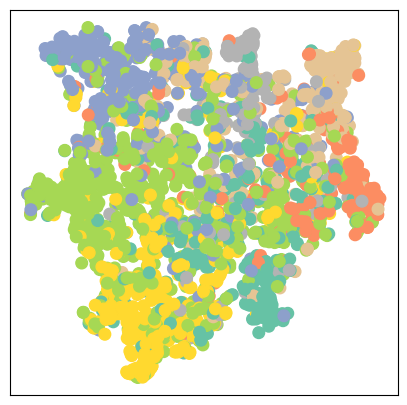

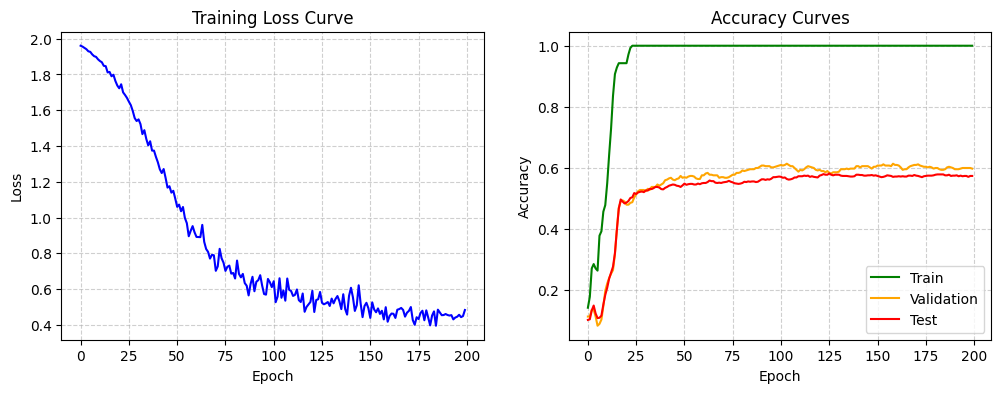

=== Final Results ===
Best Validation Accuracy: 0.6140
Final Train Accuracy: 1.0000
Final Validation Accuracy: 0.5980
Final Test Accuracy: 0.5740


In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear  # 全连接层
from torch_geometric.datasets import Planetoid  # 加载数据集
from torch_geometric.transforms import NormalizeFeatures  # 归一化
import matplotlib.pyplot as plt  # 可视化
from sklearn.manifold import TSNE  # 降维

# 加载Cora数据集
dataset = Planetoid(root='../datasets', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# 检查掩码是否正确加载
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Number of test nodes: {data.test_mask.sum()}")


# 多层感知机
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.Lin1 = Linear(dataset.num_features, hidden_channels)
        self.Lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):  # MLP是普通的前馈神经网络，只作用在节点特征上，不涉及图结构，不需要edge_index
        h = self.Lin1(x)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.Lin2(h)
        return h


# 初始化模型，隐藏层核数是16
model = MLP(hidden_channels=16)
print(model)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)


# 训练函数
def train():
    model.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清空梯度
    out = model(data.x)  # 前向传播
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数
    return loss.item()


# 测试函数
def test():
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        out = model(data.x)  # 前向传播，计算输出
        results = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = out.argmax(dim=1)  # 选择概率最大的类别作为预测结果
            acc = pred[mask].eq(data.y[mask]).float().mean().item()
            results.append(acc)
    return results


# 训练过程记录
train_losses = []
train_accs = []
val_accs = []
test_accs = []
best_val_acc = 0
best_model_state = None

# 迭代训练
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    # 记录指标
    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), 'output/03-mlp-node.pth')
    
    # 打印训练信息
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


# 降维并可视化
def visualize(h, color, epoch=None, save=False):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


# 分类结果可视化
model.eval()
out = model(data.x)
visualize(out, color=data.y)

# 训练曲线可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train', color='green')
plt.plot(val_accs, label='Validation', color='orange')
plt.plot(test_accs, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 最终评估
model.load_state_dict(best_model_state)
final_train, final_val, final_test = test()

print('=== Final Results ===')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Final Train Accuracy: {final_train:.4f}')
print(f'Final Validation Accuracy: {final_val:.4f}')
print(f'Final Test Accuracy: {final_test:.4f}')
